In [535]:
import pandas as pd
import darts as dt
import seaborn as sns
import neuralprophet as nprophet
import prophet as prophet
import numpy as np
import warnings
import matplotlib.pyplot as plt

#Configs
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [536]:
#File names

path = './data/'
transactions = 'transactions.csv'
train = 'train.csv'
test = 'test.csv'
stores = 'stores.csv'
oil = 'oil.csv'
holidays_events = 'holidays_events.csv'

In [537]:
#Reading in csv files
df_train = pd.read_csv(path + train)
df_test = pd.read_csv(path + test)
df_stores = pd.read_csv(path + stores)
df_transactions = pd.read_csv(path + transactions)
df_oil = pd.read_csv(path + oil)
df_holidays = pd.read_csv(path + holidays_events)

In [538]:
#Datetime conversion
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

In [539]:
#Missing data
df_oil.isnull().sum()

#Linear interpolation of missing values in oil timeseries
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

In [540]:
#Adding transactions, holidays, oil prices and store information to train and test, and setting date as index
df_train = df_train.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_train = df_train.merge(df_oil, on=['date'], how='left')
df_train = df_train.merge(df_stores, on=['store_nbr'], how='left')

df_test = df_test.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_test = df_test.merge(df_oil, on=['date'], how='left')
df_test = df_test.merge(df_stores, on=['store_nbr'], how='left')

#Drop type column
df_train.drop('type', axis=1, inplace=True)
df_test.drop('type', axis=1, inplace=True)

<Axes: title={'center': 'Sales by date'}, xlabel='date'>

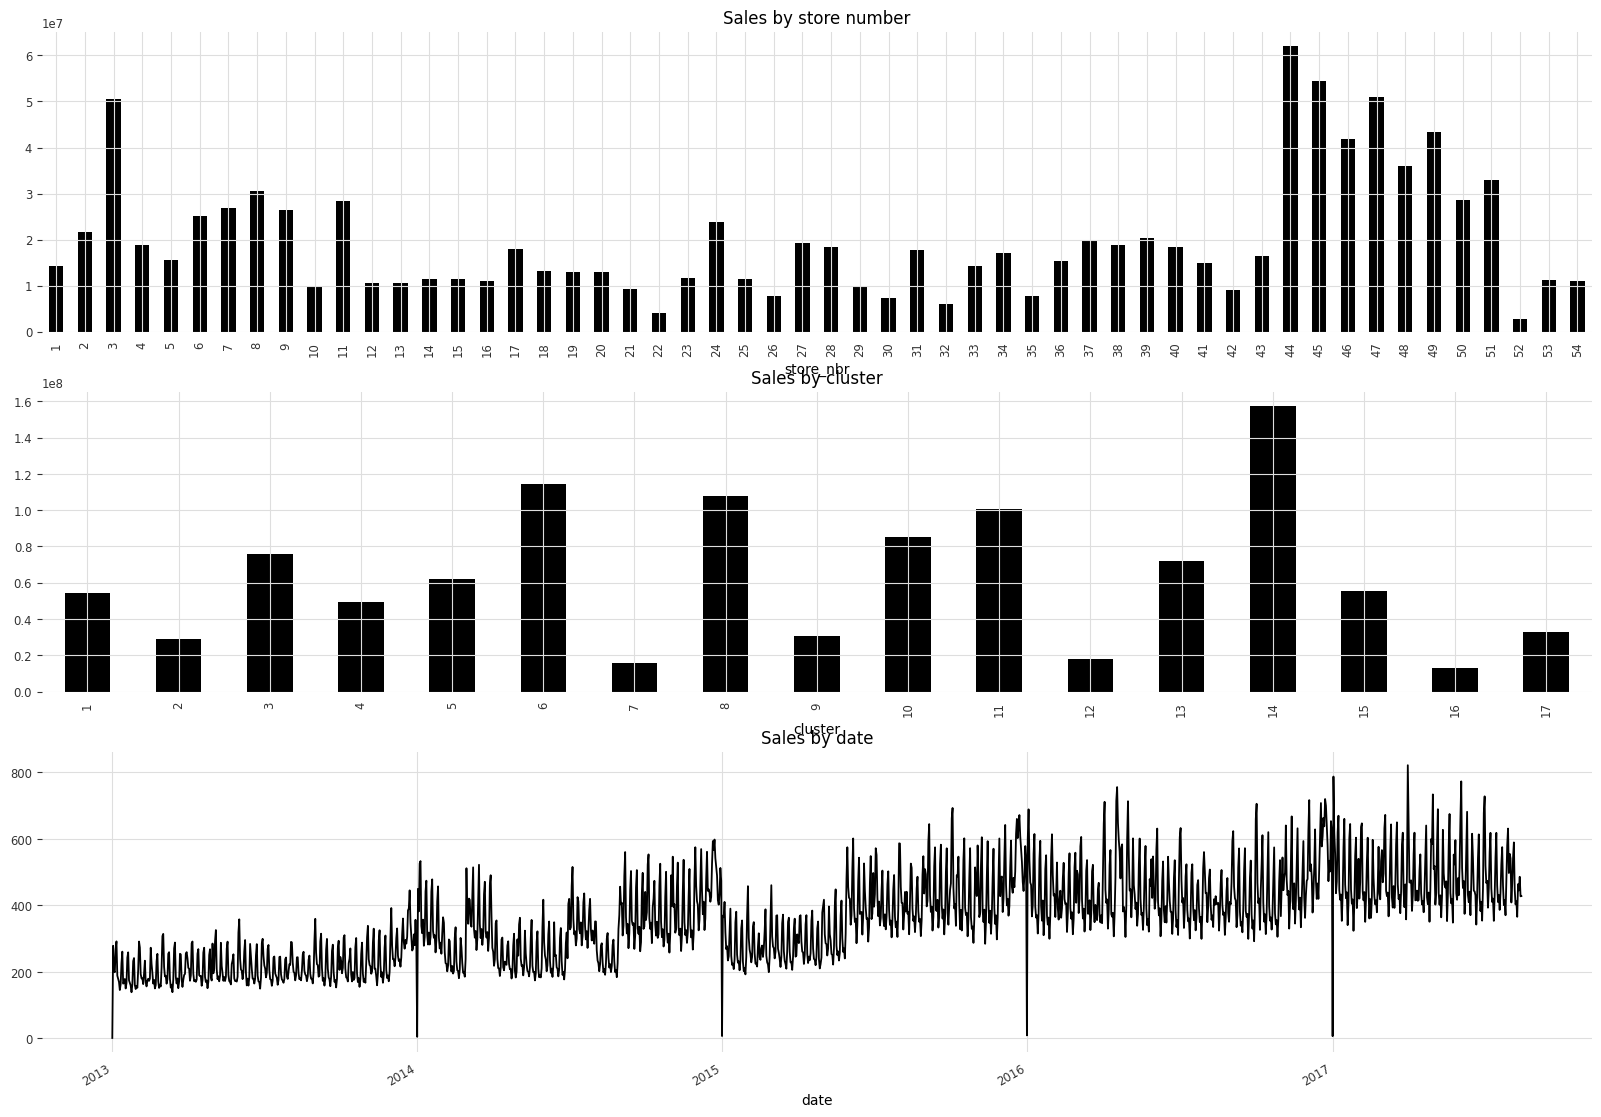

In [541]:
#Comparing sales across store_nbd
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,15))
df_train.groupby('store_nbr')['sales'].sum().plot(kind='bar', ax=ax1, title='Sales by store number')
df_train.groupby('cluster')['sales'].sum().plot(kind='bar', ax=ax2, title='Sales by cluster')
df_train.groupby('date')['sales'].mean().plot(ax=ax3, title='Sales by date')

In [542]:
#Saving train start and end dates
train_start = df_train.date.min()
train_end = df_train.date.max()

#Creating a dataframe with the mean sales per store_nbr and date
first_valid_sales = df_train.groupby(['store_nbr', 'date'])['sales'].mean()

#Getting store numbers and min date of non zero sales
first_valid_sales = first_valid_sales.reset_index()
first_valid_sales = first_valid_sales[first_valid_sales['sales'] > 0]
first_valid_sales = first_valid_sales.groupby('store_nbr')['date'].min()

#Dropping store numbers from df_train where the first non zero sales is after the start of the train set
from datetime import timedelta
new_stores = first_valid_sales[first_valid_sales > train_start + timedelta(days=1)]
new_stores

#Adding new store flag to df_train if store_nbr in new_stores
df_train['new_store'] = df_train['store_nbr'].isin(new_stores.index).astype(int)
df_train

#Adding unique store flag if store_nbr is only store_nbr in city
df_train['unique_store'] = df_train.groupby('city')['store_nbr'].transform('nunique')
df_train['unique_store'] = df_train['unique_store'].apply(lambda x: 1 if x == 1 else 0)
df_train

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,cluster,new_store,unique_store
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0,NaN,NaN,Quito,Pichincha,13,0,0
1,1,2013-01-01,1,BABY CARE,0.00,0,NaN,NaN,Quito,Pichincha,13,0,0
2,2,2013-01-01,1,BEAUTY,0.00,0,NaN,NaN,Quito,Pichincha,13,0,0
3,3,2013-01-01,1,BEVERAGES,0.00,0,NaN,NaN,Quito,Pichincha,13,0,0
4,4,2013-01-01,1,BOOKS,0.00,0,NaN,NaN,Quito,Pichincha,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.13,0,2155.00,47.57,Quito,Pichincha,6,0,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1,2155.00,47.57,Quito,Pichincha,6,0,0
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148,2155.00,47.57,Quito,Pichincha,6,0,0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8,2155.00,47.57,Quito,Pichincha,6,0,0


In [543]:
#Looking at holiday sales
df_train_holidays = df_train.merge(df_holidays, on=['date'], how='left')
df_train_holidays.groupby('description')['sales'].mean().sort_values(ascending=True)

#Dropping duplicate holidays by locale_name and date
df_holidays = df_holidays.drop_duplicates(subset=['locale_name', 'date'])

#Looking at similar events and renaming types
df_holidays.loc[df_holidays.type=='Event', 'type'] = df_holidays.description.apply(lambda x: x[0:7])

#Getting local, regional and national holiday dfs
df_holidays_local = df_holidays[df_holidays['locale'] == 'Local']
df_holidays_regional = df_holidays[df_holidays['locale'] == 'Regional']
df_holidays_national = df_holidays[df_holidays['locale'] == 'National']

#Merging holiday dfs with train dataset
df_train = df_train.merge(df_holidays_local, left_on=['date', 'city'], right_on= ['date', 'locale_name'], how='left')
df_train = df_train.merge(df_holidays_regional, left_on=['date', 'state'], right_on= ['date', 'locale_name'], how='left')
df_train = df_train.merge(df_holidays_national, on=['date'], how='left')

#Adding new year flag
df_train['new_years'] = df_train['date'].apply(lambda x: 1 if x.month == 1 and x.day == 1 else 0)

#Dropping unnecessary columns created in joining holiday dfs
df_train.drop(columns=['locale_x', 'locale_name_x', 'description_x', 'locale_y', 'locale_name_y', 'description_y', 'locale', 'locale_name', 'transferred'], inplace=True)

#Generating one event_type column which is the type of holiday if there is one, and has 'normal' if not
df_train['event_type'] = df_train['type_x'].fillna(df_train['type_y']).fillna(df_train['type']).fillna('normal')

#Dropping unnecessary type and transferred columns
df_train.drop(columns=['type_x', 'type_y', 'type', 'transferred_x', 'transferred_y'], inplace=True)

#Find dates where stores are closed (meaning sum of sales is 0 for a store_nbr)
df_train['closed'] = df_train.groupby(['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum() == 0 else 0)

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions       3861
dcoilwtico       858924
city                  0
state                 0
cluster               0
new_store             0
unique_store          0
description     2746062
new_years             0
event_type            0
closed                0
dtype: int64


<Axes: xlabel='date'>

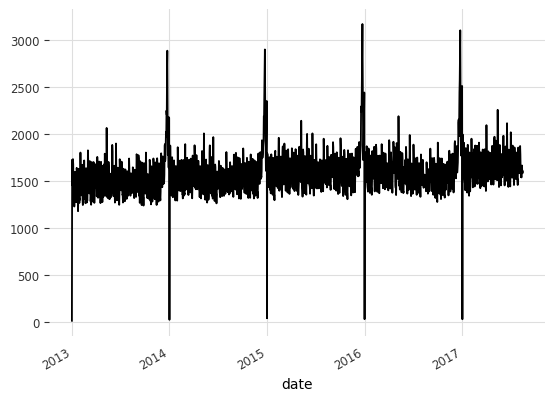

In [544]:
#Get avg amount of transactions per event_type
avg_transactions = df_train.groupby('event_type')['transactions'].mean()

#Fill in missing transactions on closed with 0
df_train.loc[df_train.closed == 1, 'transactions'] = df_train.loc[df_train.closed == 1, 'transactions'].fillna(0)

#Fill in missing transactions with avg transactions per event_type
for day in avg_transactions.index:
    if day not in ['normal', 'Work Day']:
        df_train.loc[df_train.event_type == day, 'transactions'] = df_train.loc[df_train.event_type == day, 'transactions'].fillna(avg_transactions[day])

print(df_train.isna().sum())

#Use mean transactions per store_nbr to fill in remaining missing transactions
df_train['transactions'] = df_train.groupby('store_nbr')['transactions'].transform(lambda x: x.fillna(x.mean()))


#Plot resulting transactions
df_train.groupby('date').transactions.mean().plot()

#Add total number of items on promotion on a given day feature